### Training for most common classes ###
The Neural Nets trained in transfer_leaning_resnet.ipynb are not doing so well because the data is inbalanced. Specifying class weights in a few different ways does little to help this. In this notebook, we'll see how the model performs when only trained for the top 20 classes.

First, let's see what we're dealing with:

In [3]:
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import plotting_util
import model_util
import numpy as np
from keras.models import load_model
from collections import Counter
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
HEIGHT = model_util.HEIGHT
WIDTH = model_util.WIDTH

theaters = plotting_util.load_labels()

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
vis_generator = datagen.flow_from_directory('../data/', target_size=(HEIGHT,WIDTH))

classes = Counter(vis_generator.classes)
for theater in classes.most_common():
    print(theater[0], theaters[theater[0]], '\t\t\t', theater[1])

Found 6108 images belonging to 41 classes.
32 Richard Rodgers Theatre 			 525
0 Al Hirschfeld Theatre 			 331
39 Walter Kerr Theatre 			 304
15 Gershwin Theatre 			 290
27 Music Box Theatre 			 290
23 Lyric Theatre 			 283
40 Winter Garden Theatre 			 248
34 Shubert Theatre 			 235
3 August Wilson Theatre 			 229
35 St. James Theatre 			 227
9 Brooks Atkinson Theatre 			 198
7 Broadhurst Theatre 			 174
18 Imperial Theatre 			 170
8 Broadway Theatre - 53rd Street 			 160
14 Gerald Schoenfeld Theatre 			 155
31 Palace Theatre (Broadway) 			 153
24 Majestic Theatre 			 144
22 Lyceum Theatre (Broadway) 			 141
30 New Amsterdam Theatre 			 138
13 Eugene O'Neill Theatre 			 136
20 Longacre Theatre 			 126
17 Hudson Theatre 			 124
26 Minskoff Theatre 			 113
25 Marquis Theatre 			 108
21 Lunt-Fontanne Theatre 			 105
5 Bernard B. Jacobs Theatre 			 103
37 Studio 54 			 97
10 Circle in the Square Theatre 			 93
29 Neil Simon Theatre 			 93
12 Ethel Barrymore Theatre 			 92
28 Nederlander The

This distribution is not ideal. The Richard Rodgers Theatre has more than 20x the number of images as the Stephen Sondheim Theatre.

In [14]:
classes = Counter(vis_generator.classes)
for theater in classes.most_common(20):
    print(theater[0], theaters[theater[0]], '\t\t\t', theater[1])

32 Richard Rodgers Theatre 			 525
0 Al Hirschfeld Theatre 			 331
39 Walter Kerr Theatre 			 304
15 Gershwin Theatre 			 290
27 Music Box Theatre 			 290
23 Lyric Theatre 			 283
40 Winter Garden Theatre 			 248
34 Shubert Theatre 			 235
3 August Wilson Theatre 			 229
35 St. James Theatre 			 227
9 Brooks Atkinson Theatre 			 198
7 Broadhurst Theatre 			 174
18 Imperial Theatre 			 170
8 Broadway Theatre - 53rd Street 			 160
14 Gerald Schoenfeld Theatre 			 155
31 Palace Theatre (Broadway) 			 153
24 Majestic Theatre 			 144
22 Lyceum Theatre (Broadway) 			 141
30 New Amsterdam Theatre 			 138
13 Eugene O'Neill Theatre 			 136


If we use just the top 20 theaters, this would give us a more even dataset and covers the most popular theaters on Broadway.

In [15]:
# load the top 20 classes and remove spaces to match directory names
datagen_classes = []
for theater in classes.most_common(20):
    datagen_classes.append(theaters[theater[0]].replace(" ", ""))
    
print(datagen_classes)

['RichardRodgersTheatre', 'AlHirschfeldTheatre', 'WalterKerrTheatre', 'GershwinTheatre', 'MusicBoxTheatre', 'LyricTheatre', 'WinterGardenTheatre', 'ShubertTheatre', 'AugustWilsonTheatre', 'St.JamesTheatre', 'BrooksAtkinsonTheatre', 'BroadhurstTheatre', 'ImperialTheatre', 'BroadwayTheatre-53rdStreet', 'GeraldSchoenfeldTheatre', 'PalaceTheatre(Broadway)', 'MajesticTheatre', 'LyceumTheatre(Broadway)', 'NewAmsterdamTheatre', "EugeneO'NeillTheatre"]


In [16]:
augmented_datagen = ImageDataGenerator(validation_split=0.15, rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
augmented_train_generator = augmented_datagen.flow_from_directory('../data/', subset="training", target_size=(HEIGHT,WIDTH), classes=datagen_classes)
augmented_valid_generator = augmented_datagen.flow_from_directory('../data/', subset="validation", target_size=(HEIGHT,WIDTH), classes=datagen_classes)

Found 3860 images belonging to 20 classes.
Found 671 images belonging to 20 classes.


Let's try transfer learning with just these 20 classes, starting from the weights from our highest performing model from the first transfer learning experiments. We'll remove the last dense layer that was predicting 41 classes and replace it with a new one to predict just these 20.

In [55]:
model = load_model('checkpoints/ResNet50Train.05.h5')
#model.summary()

In [56]:
new_model = model_util.remove_top_layer(model, 
                                        num_classes=20)
adam = Adam(lr=3e-4)
new_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [57]:
callbacks_list = [EarlyStopping(patience=2),
                  ModelCheckpoint(filepath='checkpoints/DataBalancingTL.{epoch:02d}.h5', monitor=["acc"], verbose=1, mode='max')]

history = new_model.fit(augmented_train_generator, 
                        validation_data=augmented_valid_generator, 
                        epochs=10, 
                        steps_per_epoch=3860/32, 
                        validation_steps=671/32,
                        callbacks=callbacks_list)

Epoch 1/10
121/120 [==============================] - 877s 7s/step - loss: 1.1524 - accuracy: 0.7192 - val_loss: 53.2963 - val_accuracy: 0.3994

Epoch 00001: saving model to checkpoints/DataBalancingTL.01.h5
Epoch 2/10
121/120 [==============================] - 825s 7s/step - loss: 0.7009 - accuracy: 0.8775 - val_loss: 10.2348 - val_accuracy: 0.6364

Epoch 00002: saving model to checkpoints/DataBalancingTL.02.h5
Epoch 3/10
121/120 [==============================] - 819s 7s/step - loss: 0.5423 - accuracy: 0.9013 - val_loss: 1.0135 - val_accuracy: 0.7273

Epoch 00003: saving model to checkpoints/DataBalancingTL.03.h5
Epoch 4/10
121/120 [==============================] - 827s 7s/step - loss: 0.3847 - accuracy: 0.9313 - val_loss: 1.2870 - val_accuracy: 0.7571

Epoch 00004: saving model to checkpoints/DataBalancingTL.04.h5
Epoch 5/10
121/120 [==============================] - 833s 7s/step - loss: 0.3705 - accuracy: 0.9272 - val_loss: 0.5362 - val_accuracy: 0.8689

Epoch 00005: saving model 

#### Results ####
This model achieves 91% validation accuracy before it starts overfitting on the training set. This result indicates that our main issue with all 41 classes is not the model architecture, but the data. If we could obtain a more balanced data set for all theaters (and more images for each theater), we could produce an accurate model.

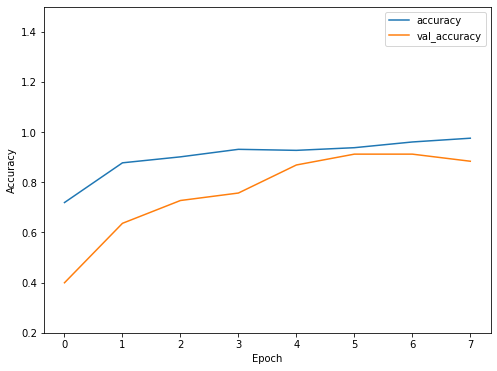

In [12]:
acc = [0.7192, 0.8775, 0.9013, 0.9313, 0.9272, 0.9378, 0.9606, 0.9756]
val_acc = [0.3994, 0.6364, 0.7273, 0.7571, 0.8689, 0.9121, 0.9121, 0.8838]


plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.5])
plt.legend(loc='upper right')

In [4]:
best_model = load_model('checkpoints/DataBalancingTL.06.h5')

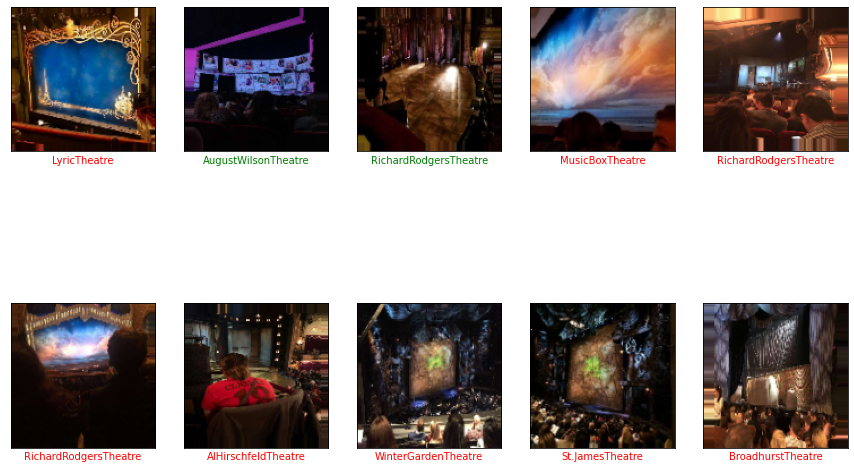

In [29]:
import plotting_util

valid_examples = augmented_valid_generator.next()

for im in valid_examples[0]:
    im_reshaped = tf.reshape(im, [-1, HEIGHT, WIDTH, 3])
    one_hot = np.zeros((20))
    one_hot[np.argmax(best_model.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_labeled_class_examples(classifications,datagen_classes,valid_examples[1],valid_examples[0])

In [6]:
import plotting_util
import os

datagen_classes = ["VivianBeaumontTheatre", "WalterKerrTheatre", "AlHirschfeldTheatre"]
classifications = []
batch_size = 5;

theaters = open(os.path.abspath("../scripts/theaters.txt")).read().split('\n')
test_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(directory='../test-data/',
                                                                       batch_size=batch_size,
                                                                       shuffle=True,
                                                                       target_size=(128, 128),
                                                                       classes=datagen_classes)

Found 5 images belonging to 3 classes.


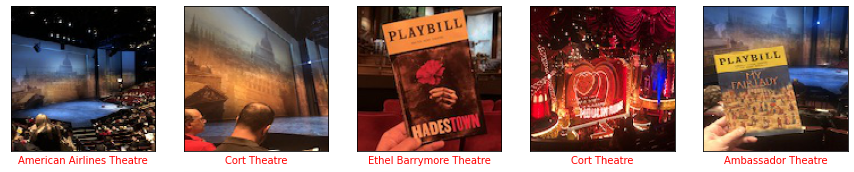

In [10]:
test_examples = test_data_gen.next()

for im in test_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(best_model.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_test_examples(classifications,datagen_classes,test_examples[1],test_examples[0],count=batch_size)